### 2. Hyperparameter Tuning using Randomised Search

#### Setup with Libraries and Utilities

In [2]:
import pandas as pd
import numpy as np
import os
import json
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import time

from utils.metrics import kpi_ML
from utils.normalisation import normalise_data

import warnings
warnings.filterwarnings("ignore")

#### Loading Training and Test Data Splits

In [3]:
X_train = pd.read_csv('../data_splits/X_train.csv')
X_test = pd.read_csv('../data_splits/X_test.csv')
y_train = pd.read_csv('../data_splits/y_train.csv').values.ravel()  # Convert to 1D array if needed
y_test = pd.read_csv('../data_splits/y_test.csv').values.ravel()

#### Normalise the Data

In [4]:
X_train_scaled, X_test_scaled = normalise_data(X_train, X_test)

#### Randomised Search for Optimising Random Forest Regression Parameters

In [5]:
rf_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_features': ['auto', 'sqrt'],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

rf_random_search = RandomizedSearchCV(estimator=RandomForestRegressor(random_state=42), 
                                      param_distributions=rf_param_grid, 
                                      n_iter=50, cv=3, n_jobs=-1, verbose=1, random_state=42)

start_time_rf2 = time.time()
rf_random_search.fit(X_train_scaled, y_train)
training_time_rf2 = (time.time() - start_time_rf2) / 60

Fitting 3 folds for each of 50 candidates, totalling 150 fits


/Users/jonathanduquegonzalez/myenv/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/Users/jonathanduquegonzalez/myenv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
81 fits failed out of a total of 150.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
24 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/jonathanduquegonzalez/myenv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_par

#### Printing and Saving Best Parameters for Tuned Random Forest Regression Model

In [6]:
best_rf = rf_random_search.best_estimator_

print("Best parameters found: ", rf_random_search.best_params_)

Best parameters found:  {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': None, 'bootstrap': True}


In [7]:
best_params_path = '../model_metrics/statistical_models/best_params_tuned_rf.json'

best_params_tuned_rf = rf_random_search.best_params_

try:
    with open(best_params_path, 'w') as file:
        json.dump(best_params_tuned_rf, file)
    print(f"Best parameters saved to {best_params_path}")
except Exception as e:
    print(f"Error saving best parameters: {e}")

Best parameters saved to ../model_metrics/statistical_models/best_params_tuned_rf.json


#### Evaluating and Saving Performance Metrics for Tuned Random Forest Regressor

In [8]:
Y_train_pred = best_rf.predict(X_train_scaled)
Y_test_pred = best_rf.predict(X_test_scaled)

metrics_tuned_rf = kpi_ML(y_train, Y_train_pred, y_test, Y_test_pred, "Tuned Random Forest Regressor")
metrics_tuned_rf['Training Time rf2 (min)'] = round(training_time_rf2, 1)

print(metrics_tuned_rf)

                                MAE  RMSE  Bias   R²  Training Time rf2 (min)
Tuned Random Forest Regressor                                                
Train                          22.8  39.4   0.0  0.9                     13.9
Test                           35.8  61.3   0.1  0.8                     13.9


#### Analysis of Simple vs. Tuned Random Forest Regressors and Future Model Enhancements

The errors are higher in the test set compared to the training set, which is expected. The model performs quite well but shows some degree of overfitting, as indicated by the higher test errors. Despite this, the R² values of 0.9 for the training set and 0.8 for the test set indicate that the model explains most of the variance in the data. The bias is very low for both sets, suggesting that the model is not systematically underpredicting or overpredicting.

In conclusion, the `Simple Random Forest Regressor` not only trains faster but also achieves better accuracy on both training and testing datasets compared to the `Tuned Random Forest Regressor`. This indicates that, for this specific dataset and modelling task, the default hyperparameters of the Random Forest are highly effective, and additional tuning does not yield performance gains but rather introduces inefficiencies.

In the next model, we will apply polynomial features to enhance the model. Following that, we will test other ensemble methods such as `Gradient Boosting` or `XGBoost`, which might handle the data patterns differently and potentially improve performance.

In [9]:
results_dir = '../model_metrics/statistical_models'
os.makedirs(results_dir, exist_ok=True)  # Ensure the directory exists
results_path = os.path.join(results_dir, 'results_tuned_rf.csv')
metrics_tuned_rf.to_csv(results_path, index=False)
print("Tuned Random Forest results saved.")

Tuned Random Forest results saved.


#### Extracting and Plotting Feature Importances
We'll extract and visualise the feature importances to compare both the original and transformed features.

In [10]:
feature_importances = best_rf.feature_importances_
features = X_train.columns
importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)
print("\nFeature Importances:")
print(importance_df)


Feature Importances:
         Feature  Importance
1           Dept    0.733177
4           Size    0.081226
0          Store    0.040387
3           Type    0.034283
12           CPI    0.025836
14          Week    0.017214
13  Unemployment    0.016047
5    Temperature    0.013455
6     Fuel_Price    0.011584
11     MarkDown5    0.006208
9      MarkDown3    0.005625
7      MarkDown1    0.004998
10     MarkDown4    0.004102
8      MarkDown2    0.002908
2      IsHoliday    0.001576
15          Year    0.001372


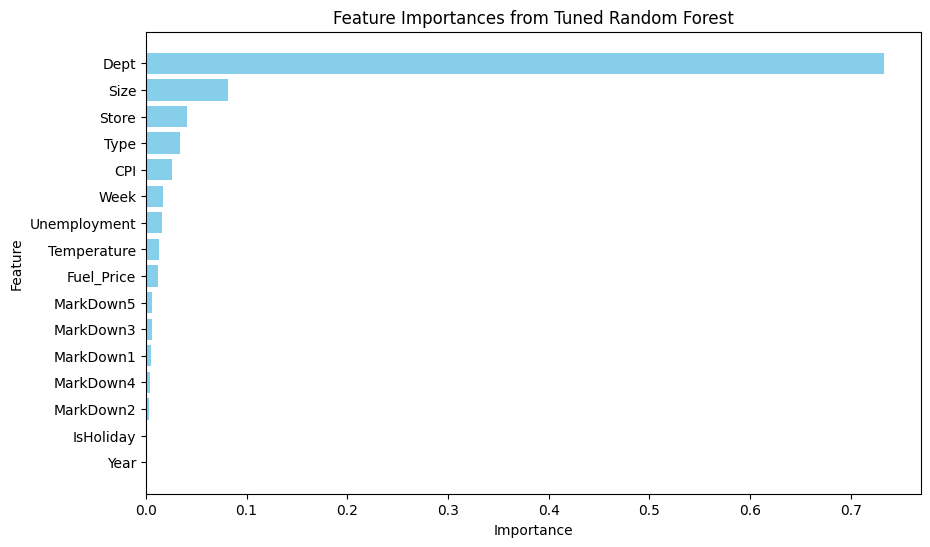

In [11]:
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances from Tuned Random Forest')
plt.gca().invert_yaxis()  
plt.savefig('../model_metrics/statistical_models/Feature_Importances_from_Tuned_Random_Forest_rf.png', bbox_inches='tight')
plt.show()